# Comparison of parameters for jet tagging in fast sim and full sim

Notes: 

- `jet_npfcand` and `jet_nconst` is the same / filled with the same value in full sim


In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_fullsim = "/home/saaumill/FullSimTagger/src/fullsim_tree.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v2/stage2_Hbb.root"

file_fu = uproot.open(path_fullsim)
tree_fu = file_fu["tree;1"]

file_fa = uproot.open(path_fastsim)
tree_fa = file_fa["tree;1"]

In [3]:
df_fa = tree_fa.arrays(entry_start=0, entry_stop=200, library="np")
df_fu = tree_fu.arrays(entry_start=0, entry_stop=200, library="np")

Check if trees have the same key. Apart from `['event_number','n_hit','n_part']` @Dolores why do we need them when initializing?

In [4]:
list_fu = [item for item in tree_fu.keys() if item not in ['event_number','n_hit','n_part']]

set_fa = set(tree_fa.keys())
set_fu = set(list_fu)

print(set_fa == set_fu)

True


Now let's check if the distributions look the same!

### recojet_isX

In [5]:
len(df_fu['recojet_isB'])

200

In [6]:
def histograms(keys, n, k, figsize=(13, 2), bins=50, conc=False):
    fig, axs = plt.subplots(n, k, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.set_title(keys[i])
        # set same range if not specified
        try:
            fa = df_fa[keys[i]]
            fu = df_fu[keys[i]]
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        except ValueError:
            fa = np.concatenate(df_fa[keys[i]])
            fu = np.concatenate(df_fu[keys[i]])
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        # plot
        if conc==False:
            ax.hist(df_fa[keys[i]], bins=bins, range=combined_range, alpha=0.55, label='FastSim') # set density=True to normalize
            ax.hist(df_fu[keys[i]], bins=bins, range=combined_range, alpha=0.55, label='FullSim')
        else: 
            ax.hist(np.concatenate(df_fa[keys[i]]), bins=bins, range=combined_range, alpha=0.55, label='FastSim') # set density=True to normalize
            ax.hist(np.concatenate(df_fu[keys[i]]), bins=bins, range=combined_range, alpha=0.55, label='FullSim')
    
    plt.legend()
    plt.tight_layout()

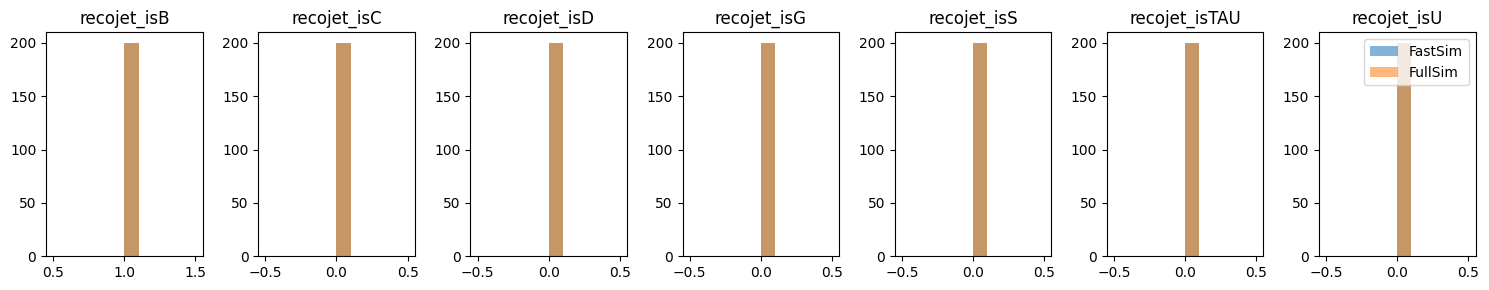

In [7]:
keys = ['recojet_isB',
 'recojet_isC',
 'recojet_isD',
 'recojet_isG',
 'recojet_isS',
 'recojet_isTAU',
 'recojet_isU']

histograms(keys, 1, 7, figsize=(15, 3), bins=10)

**Conclusion**: we see that in the full sim the reco PID of the quark is wrong! Although we have only b jets it classifies very jet as c ...

Well... not sure that goes wrong here. I definitely use b quarks for fullsim, why is it marked as c? I double checked the PDG IDs.

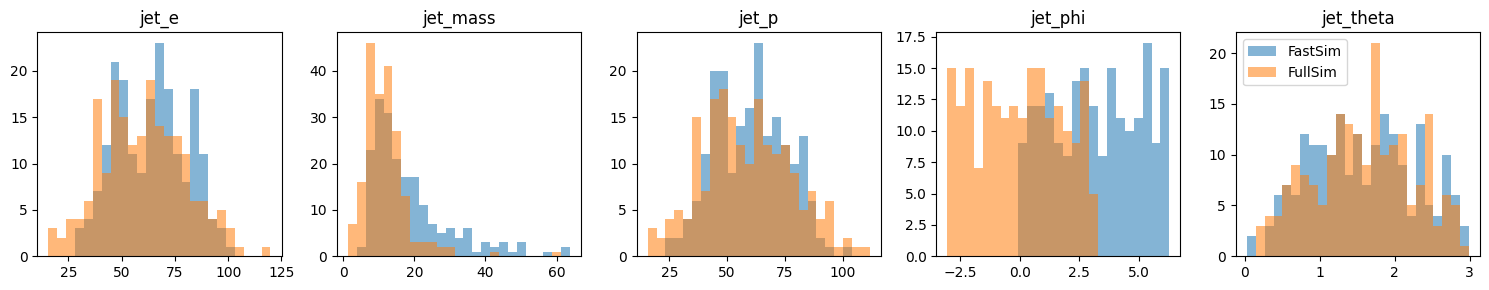

In [8]:
keys = ['jet_e',
 'jet_mass',
 'jet_p',
 'jet_phi',
 'jet_theta']


histograms(keys, 1, 5, figsize=(15, 3), bins=25)

- `jet_e` seems fine
- `jet_mass` seems fine
- `jet_p` seems fine
- `jet_phi` seems fine -> only other range! $\phi_{\mathrm{FullSim}} \in [-\pi, \pi]$ but $\phi_{\mathrm{FastSim}} \in [0, 2\pi]$
- `jet_theta` seems fine


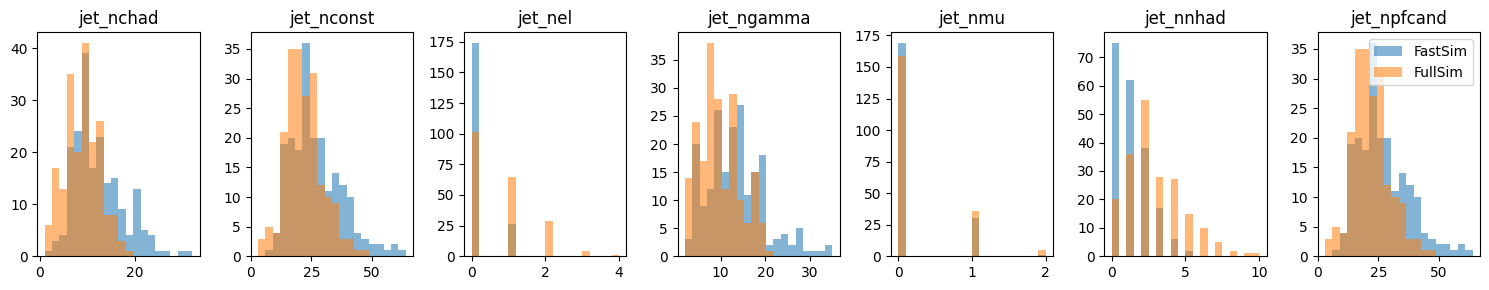

In [9]:
keys = ['jet_nchad',
 'jet_nconst',
 'jet_nel',
 'jet_ngamma',
 'jet_nmu',
 'jet_nnhad',
 'jet_npfcand']

histograms(keys, 1, 7, figsize=(15, 3), bins=20)

Reasonable enough?
-> more neutral hadrons than with fast sim... how I do it is to check for tracks and if no track and no electron or muon its a neutral hadron...

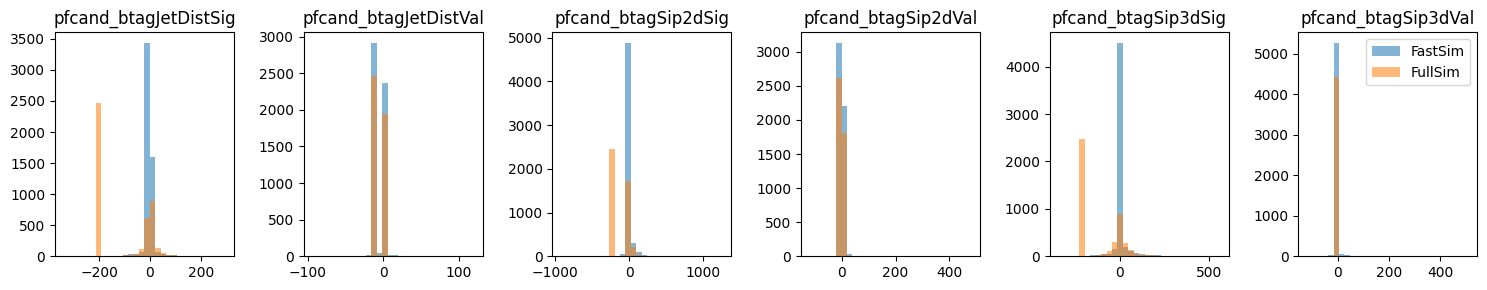

In [10]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

histograms(keys, 1, 6, figsize=(15, 3), bins=30, conc=True)

Okay, Michele said that I should always compare the particles in a jet with the highest amount of energy and not the whole distribution because it might differ in the tails. So let's do that instead:

In [11]:
def get_index_highest_energy_particle(df, k=3, type=211):
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
    index = np.zeros((particles_e.shape[0], k), dtype=int)
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argpartition(part_e, -k)[-k:]
        ind = ind[np.argsort(part_e[ind])[::-1]]
        index[i] = ind
    return index

In [50]:
def get_index_charged_hadrons(df):
    if df == 'fa':
        types = df_fa['pfcand_type']
        num = 130
    elif df == 'fu':
        types = df_fu['pfcand_type']
        num = 211
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(abs(types[i]) == num)[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [73]:
def get_value_highest_energy_particle(df, k=3):
    """return the index of the k highest energy charged hadron in each event"""
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
        mask_chad = get_index_charged_hadrons('fa')
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
        mask_chad = get_index_charged_hadrons('fu')
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argpartition(part_e, -k)
        ind = ind[np.argsort(part_e[ind])[::-1]]
        mask = mask_chad[i]
        c_index = ind[mask]
        index_charged.append(c_index[:k])
    return index_charged

In [74]:
index_charged_3E_fu = get_value_highest_energy_particle("fu")
index_charged_3E_fa = get_value_highest_energy_particle("fa")

In [51]:
mask_chad_fa = get_index_charged_hadrons("fa")
mask_chad_fu = get_index_charged_hadrons("fu")

In [52]:
index_fa = get_index_highest_energy_particle("fa")
index_fu = get_index_highest_energy_particle("fu")

In [15]:
# Access the desired elements
def get_elements(df_value, index):
    return np.array([df_value[i][index[i]] for i in range(len(df_value))])


In [75]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [138]:
def plot_key_highest_e_chad(key, k=3, range=None, bins=20, log=False):
    fig, axs = plt.subplots(1, k, figsize=(10,3))

    a_list = get_chad_elements(df_fa[key], index_charged_3E_fa)
    b_list = get_chad_elements(df_fu[key], index_charged_3E_fu)

    for i, ax in enumerate(axs.flat):
        a = a_list[i]
        b = b_list[i]

        if range == None:
            combined_min = min(a.min(), b.min())
            combined_max = max(a.max(), b.max())
            combined_range = (combined_min, combined_max)
        else:
            combined_range = range
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        if log:
            ax.set_yscale('log')
        ax.legend()
        
    plt.show()

In [16]:
def plot_key_highest_e_part(key, k=3, range=None, bins=20, log=False):
    fig, axs = plt.subplots(1, k, figsize=(10,3))
    for i, ax in enumerate(axs.flat):
        a = get_elements(df_fa[key], index_fa)[:, i]
        b = get_elements(df_fu[key], index_fu)[:, i]

        if range == None:
            combined_min = min(a.min(), b.min())
            combined_max = max(a.max(), b.max())
            combined_range = (combined_min, combined_max)
        else:
            combined_range = range
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        if log:
            ax.set_yscale('log')
        ax.legend()
        
    plt.show()

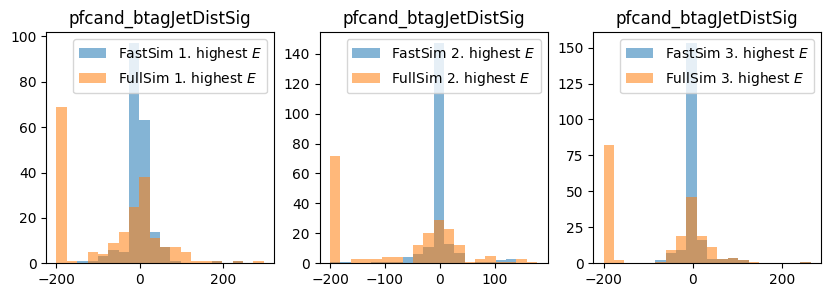

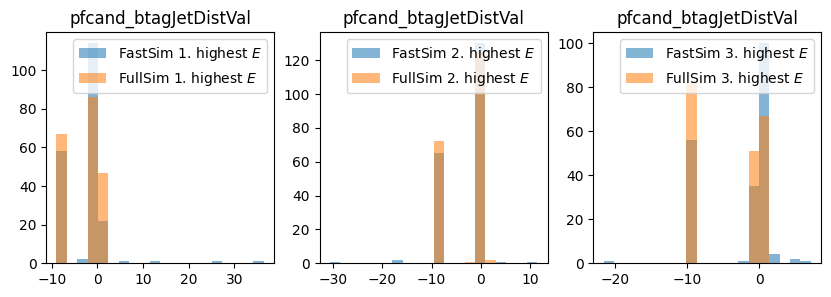

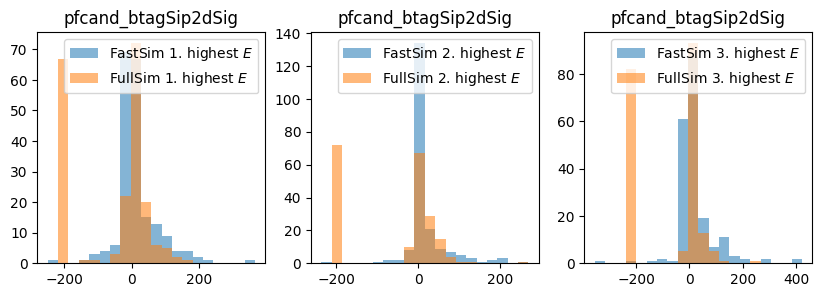

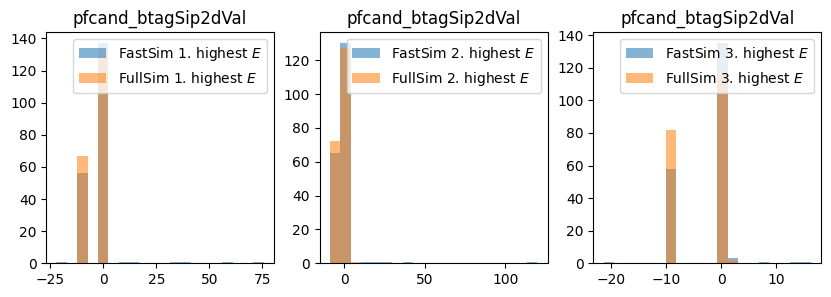

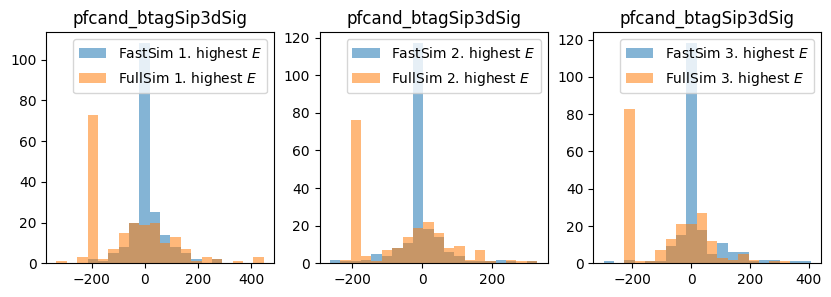

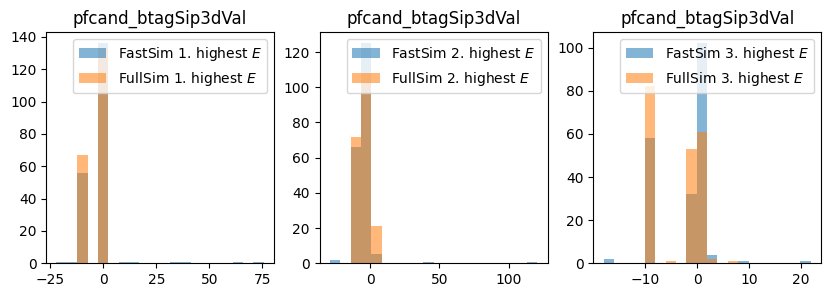

In [17]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

for key in keys:
    plot_key_highest_e_part(key)

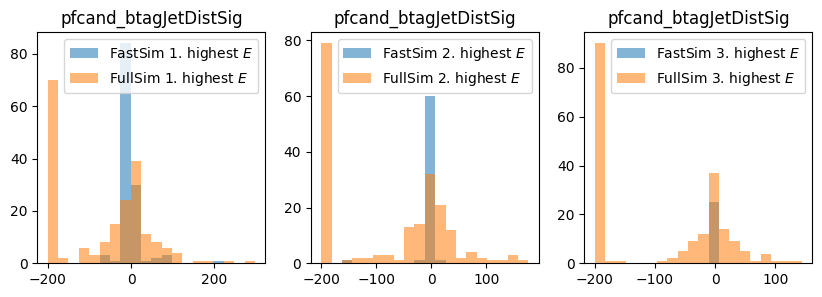

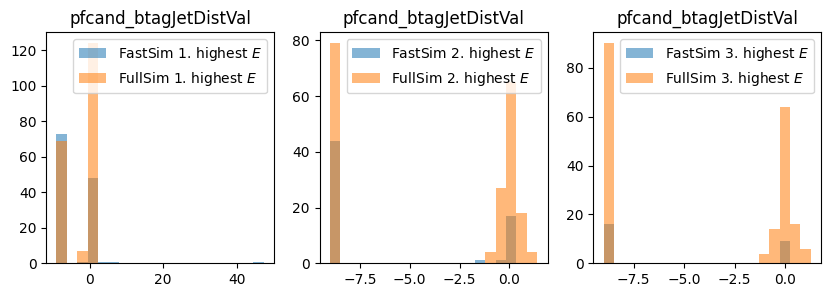

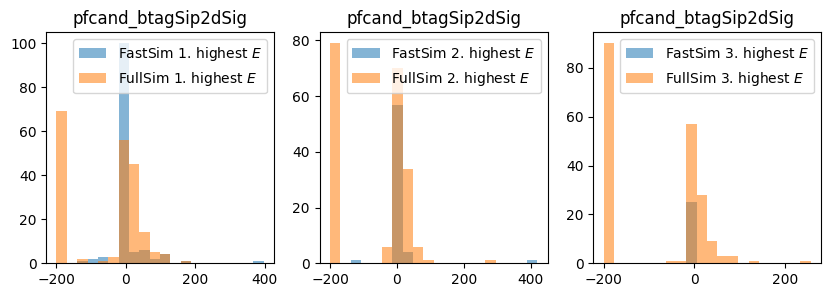

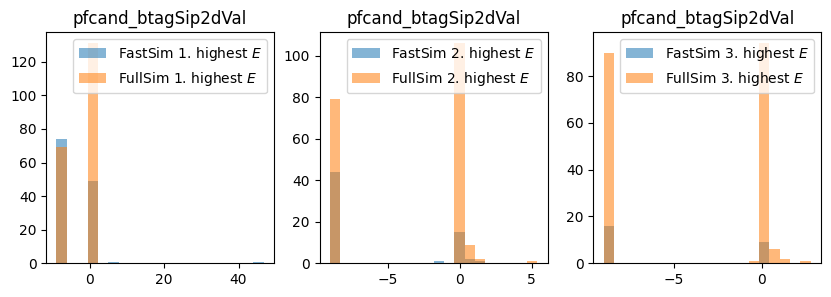

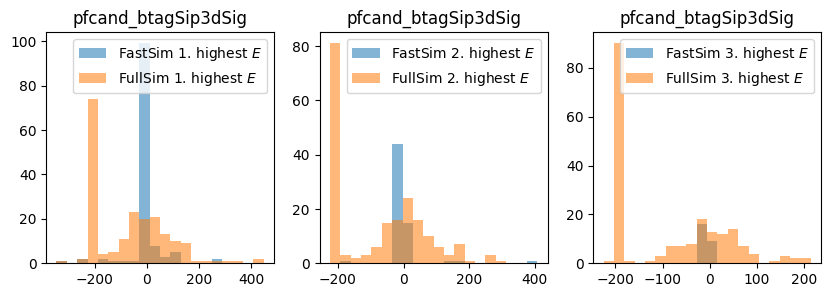

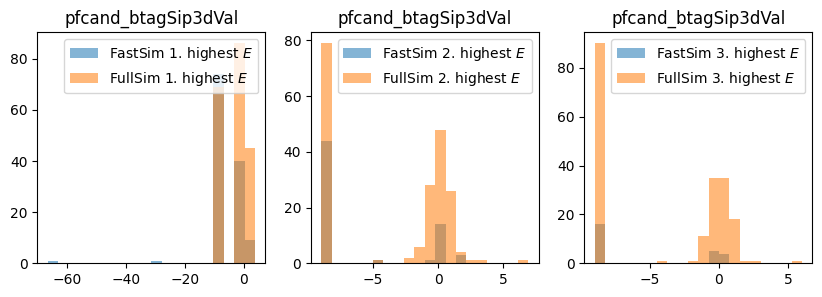

In [139]:
# these plots make even more sense than the one above because we look at charged hadrons only which leave a track!

keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

for key in keys:
    plot_key_highest_e_chad(key)

You see the difference of setting `Sig` to -200 instead of -9. 

Well and doing this for chad only doesn't make sense because there are just fewer chad in fastsim than in fullsim, so the comparison is nahh :/ I could normalize the plots though?

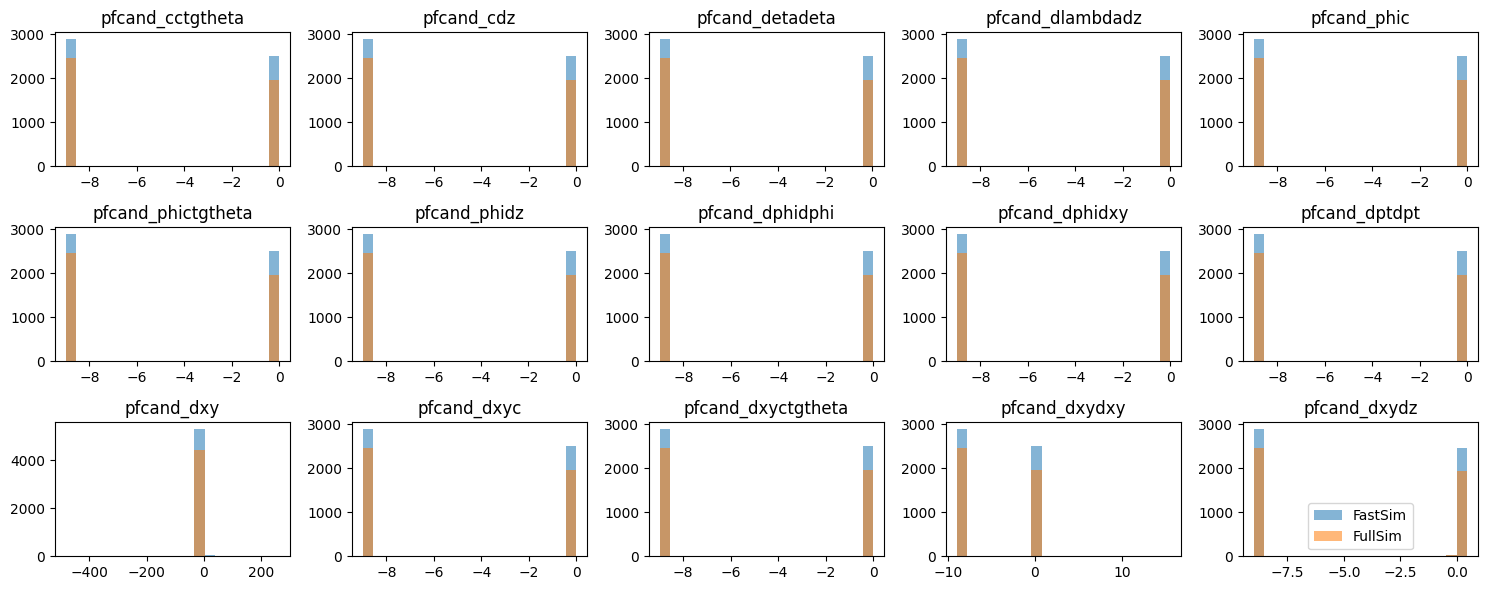

In [18]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']

histograms(keys, 3, 5, figsize=(15, 6), bins=20, conc=True)

Well, we see that at least the -9 makes sense. But let's check for the distributions for the highest energy particles. And cut the region where the -9 is to get a better understanding of the distributions

In [19]:
variables_pfcand = {
    "pfcand_erel_log": {
        "name": "pfcand_erel_log",
        "title": "log(E_{i}/E_{jet})",
        "bin": 100,
        "xmin": -3,
        "xmax": 0,
        "scale": "log",
    },
    "pfcand_thetarel": {
        "name": "pfcand_thetarel",
        "title": "#theta_{rel}",
        "bin": 100,
        "xmin": 0.0,
        "xmax": 3.0,
        "scale": "lin",
    },
    "pfcand_phirel": {
        "name": "pfcand_phirel",
        "title": "#phi_{rel}",
        "bin": 100,
        "xmin": -3.14,
        "xmax": 3.14,
        "scale": "lin",
    },
    "pfcand_dptdpt": {
        "name": "pfcand_dptdpt",
        "title": "#sigma(#omega)^{2}",
        "bin": 100,
        "xmin": 0.0,
        "xmax": 2e-09,
        "scale": "log",
    },
    "pfcand_detadeta": {
        "name": "pfcand_detadeta",
        "title": "#sigma(tan(#lambda))^{2}",
        "bin": 100,
        "xmin": 0.0,
        "xmax": 0.02,
        "scale": "log",
    },
    "pfcand_dphidphi": {
        "name": "pfcand_dphidphi",
        "title": "#sigma(#phi))^{2}",
        "bin": 100,
        "xmin": 0.0,
        "xmax": 0.0015,
        "scale": "log",
    },
    "pfcand_dxydxy": {
        "name": "pfcand_dxydxy",
        "title": "#sigma(d_{xy}))^{2}",
        "bin": 100,
        "xmin": 0.0,
        "xmax": 0.20,
        "scale": "log",
    },
    "pfcand_dzdz": {
        "name": "pfcand_dzdz",
        "title": "#sigma(d_{z}))^{2}",
        "bin": 100,
        "xmin": 0.0,
        "xmax": 0.50,
        "scale": "log",
    },
    "pfcand_dxydz": {
        "name": "pfcand_dxydz",
        "title": "C(d_{xy},d_{z})",
        "bin": 100,
        "xmin": -10,
        "xmax": 10,
        "scale": "log",
    },
    "pfcand_dphidxy": {
        "name": "pfcand_dphidxy",
        "title": "C(#phi,d_{z})",
        "bin": 100,
        "xmin": -0.1,
        "xmax": 0,
        "scale": "log",
    },
    "pfcand_dlambdadz": {
        "name": "pfcand_dlambdadz",
        "title": "C(tan(#lambda),d_{z})",
        "bin": 100,
        "xmin": -0.5,
        "xmax": 0.1,
        "scale": "log",
    },
    "pfcand_dxyc": {
        "name": "pfcand_dxyc",
        "title": "C(#omega,d_{xy})",
        "bin": 100,
        "xmin": -0.2,
        "xmax": 0.1,
        "scale": "log",
    },
    "pfcand_dxyctgtheta": {
        "name": "pfcand_dxyctgtheta",
        "title": "C(tan(#lambda),d_{xy})",
        "bin": 100,
        "xmin": -0.025,
        "xmax": 0.025,
        "scale": "log",
    },
    "pfcand_phic": {
        "name": "pfcand_phic",
        "title": "C(#omega,#phi)",
        "bin": 100,
        "xmin": -1e-06,
        "xmax": 1e-06,
        "scale": "log",
    },
    "pfcand_phidz": {
        "name": "pfcand_phidz",
        "title": "C(#phi,d_{z})",
        "bin": 100,
        "xmin": -0.05,
        "xmax": 0.05,
        "scale": "log",
    },
    "pfcand_phictgtheta": {
        "name": "pfcand_phictgtheta",
        "title": "C(tan(#lambda),#phi)",
        "bin": 100,
        "xmin": -0.1e-03,
        "xmax": 0.5e03,
        "scale": "log",
    },
    "pfcand_cdz": {
        "name": "pfcand_cdz",
        "title": "C(#omega,d_{z})",
        "bin": 100,
        "xmin": -0.5e-03,
        "xmax": 0.1e-03,
        "scale": "log",
    },
    "pfcand_cctgtheta": {
        "name": "pfcand_cctgtheta",
        "title": "C(#omega, tan(#lambda))",
        "bin": 100,
        "xmin": -1e-06,
        "xmax": 20e-06,
        "scale": "log",
    },
    "pfcand_mtof": {
        "name": "pfcand_mtof",
        "title": "m_{ToF} [GeV]",
        "bin": 100,
        "xmin": 0,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_dndx": {
        "name": "pfcand_dndx",
        "title": "dN/dx [mm^{-1}]",
        "bin": 100,
        "xmin": 0,
        "xmax": 5,
        "scale": "lin",
    },
    "pfcand_charge": {
        "name": "pfcand_charge",
        "title": "Q",
        "bin": 2,
        "xmin": -0.5,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_isMu": {
        "name": "pfcand_isMu",
        "title": "is muon",
        "bin": 2,
        "xmin": -0.5,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_isEl": {
        "name": "pfcand_isEl",
        "title": "is electron",
        "bin": 2,
        "xmin": -0.5,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_isChargedHad": {
        "name": "pfcand_isChargedHad",
        "title": "is charged hadron",
        "bin": 2,
        "xmin": -0.5,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_isGamma": {
        "name": "pfcand_isGamma",
        "title": "is photon",
        "bin": 2,
        "xmin": -0.5,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_isNeutralHad": {
        "name": "pfcand_isNeutralHad",
        "title": "is neutral hadron",
        "bin": 2,
        "xmin": -0.5,
        "xmax": 1.5,
        "scale": "lin",
    },
    "pfcand_type": {
        "name": "pfcand_type",
        "title": "PDG code",
        "bin": 10000,
        "xmin": -5000,
        "xmax": 5000,
        "scale": "lin",
    },
    "pfcand_dxy": {
        "name": "pfcand_dxy",
        "title": "d_{xy} [mm]",
        "bin": 100,
        "xmin": -0.5,
        "xmax": 0.5,
        "scale": "log",
    },
    "pfcand_dz": {
        "name": "pfcand_dz",
        "title": "d_{z} [mm]",
        "bin": 100,
        "xmin": -0.5,
        "xmax": 0.5,
        "scale": "log",
    },
}

keys = ['pfcand_cctgtheta', 'pfcand_cdz', 'pfcand_detadeta', 'pfcand_dlambdadz', 'pfcand_phic',
        'pfcand_phictgtheta', 'pfcand_phidz', 'pfcand_dphidphi', 'pfcand_dphidxy', 'pfcand_dptdpt',
        'pfcand_dxy', 'pfcand_dxyc', 'pfcand_dxyctgtheta', 'pfcand_dxydxy', 'pfcand_dxydz', 
        'pfcand_dz', 'pfcand_dzdz']

xscale = {key: [variables_pfcand[key]["scale"]] for key in keys}


In [20]:
xscale

{'pfcand_cctgtheta': ['log'],
 'pfcand_cdz': ['log'],
 'pfcand_detadeta': ['log'],
 'pfcand_dlambdadz': ['log'],
 'pfcand_phic': ['log'],
 'pfcand_phictgtheta': ['log'],
 'pfcand_phidz': ['log'],
 'pfcand_dphidphi': ['log'],
 'pfcand_dphidxy': ['log'],
 'pfcand_dptdpt': ['log'],
 'pfcand_dxy': ['log'],
 'pfcand_dxyc': ['log'],
 'pfcand_dxyctgtheta': ['log'],
 'pfcand_dxydxy': ['log'],
 'pfcand_dxydz': ['log'],
 'pfcand_dz': ['log'],
 'pfcand_dzdz': ['log']}

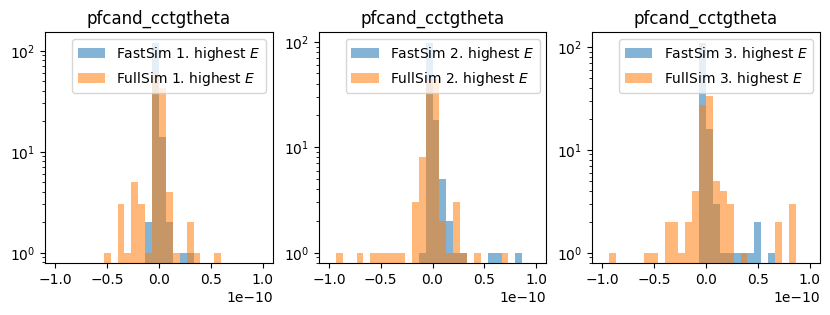

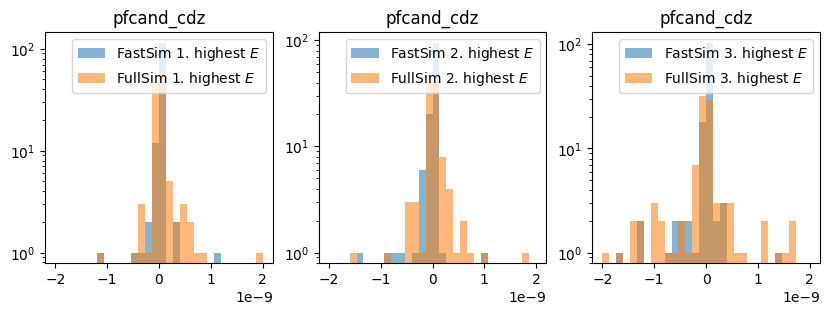

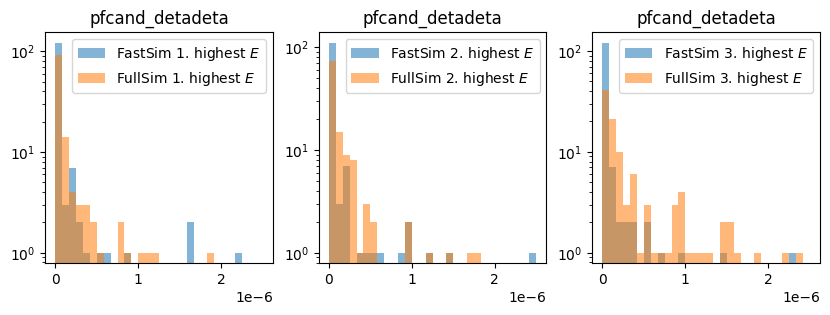

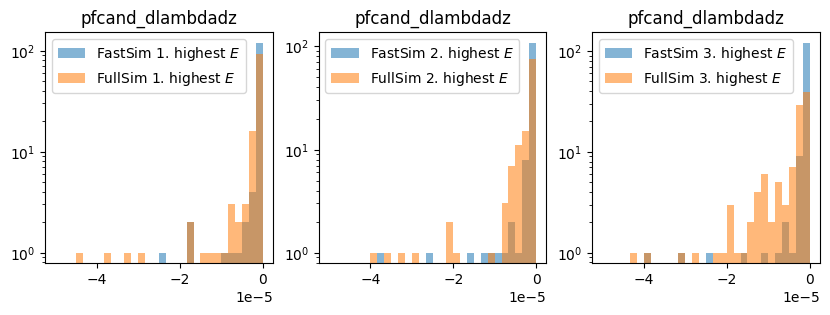

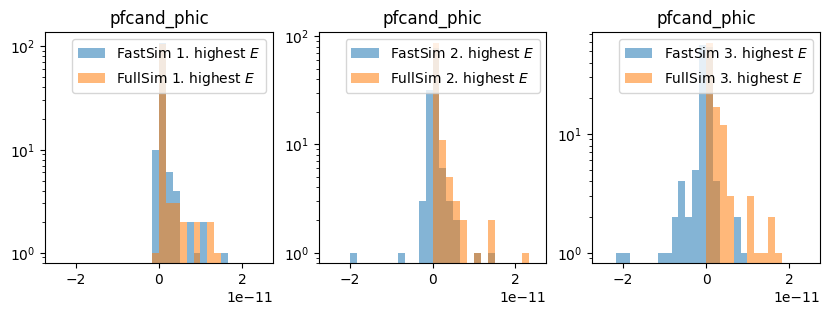

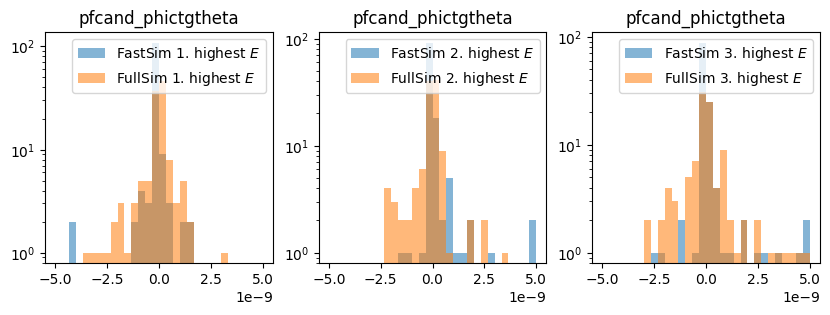

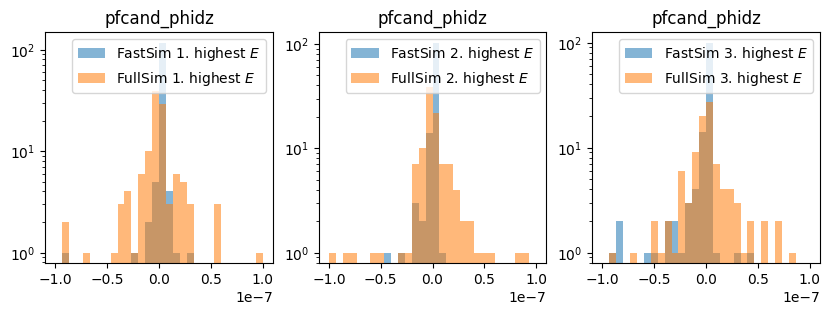

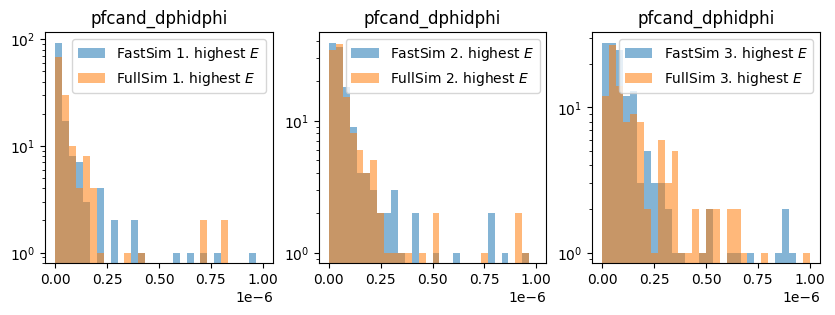

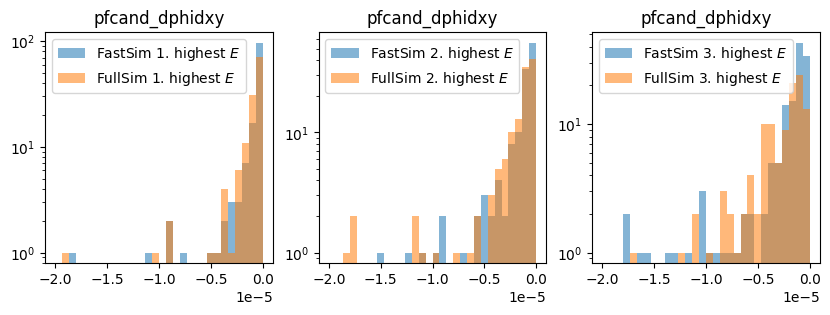

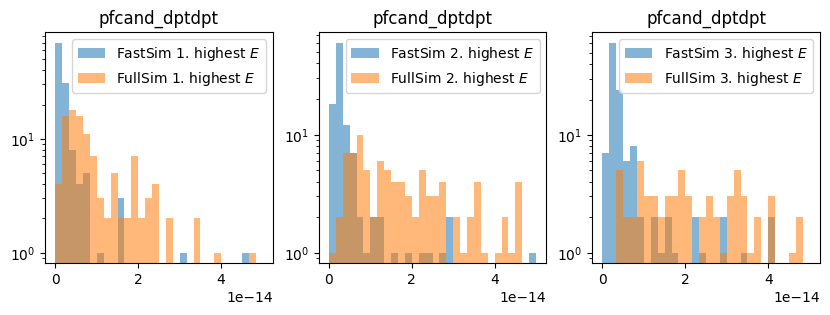

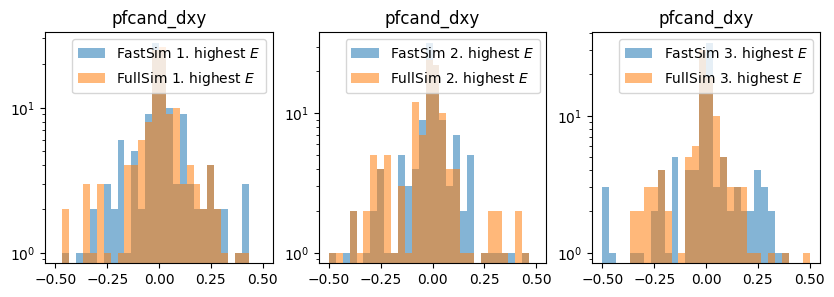

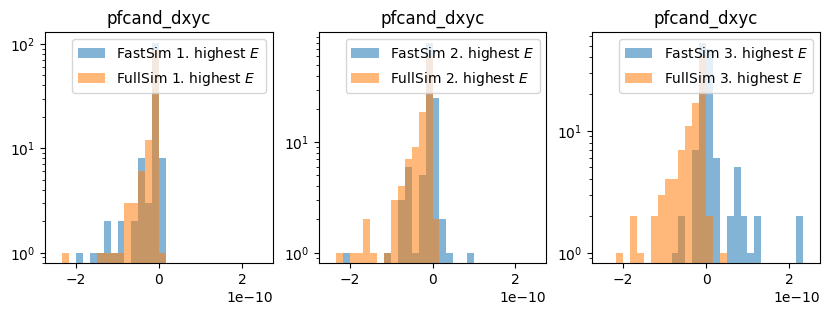

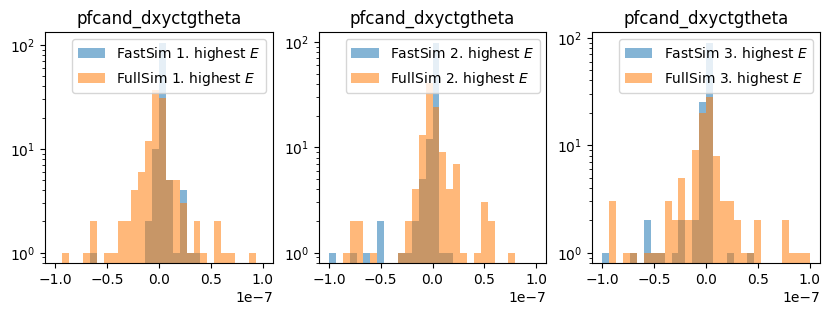

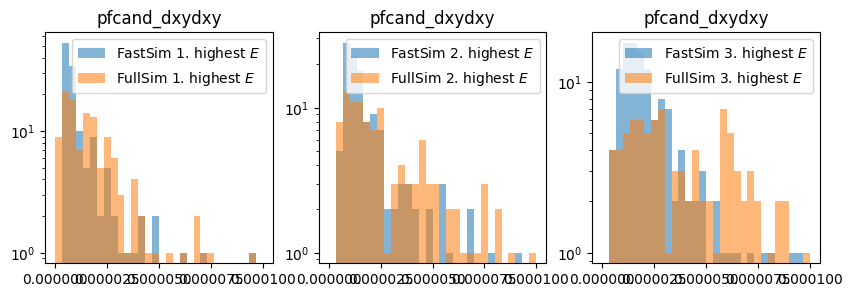

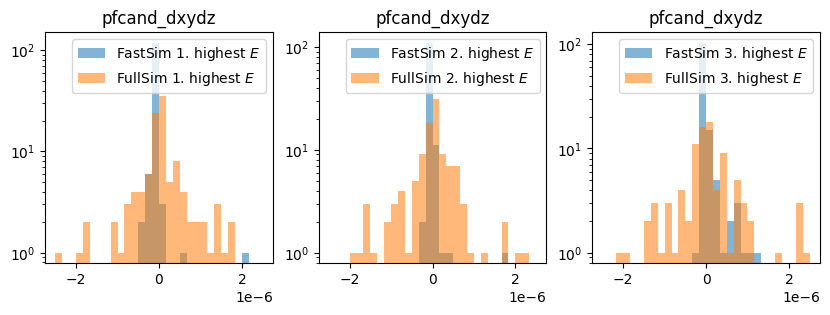

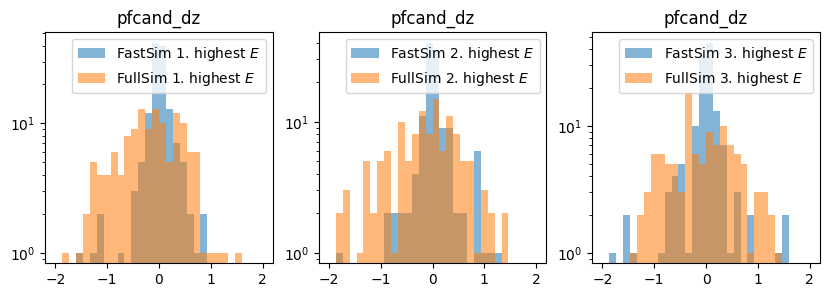

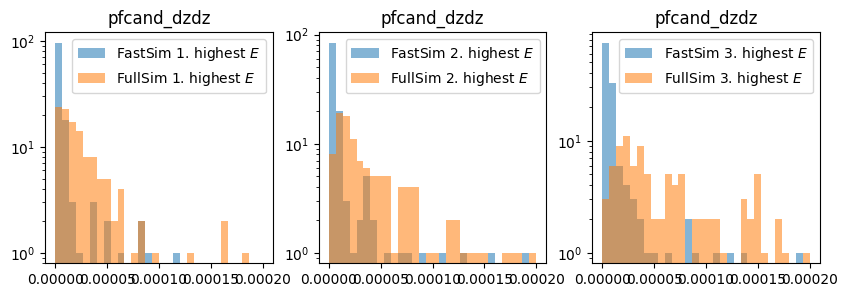

In [140]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']
ranges = {
    'pfcand_dz': [-2, 2],
    'pfcand_dxy': [-0.5, 0.5],
    'pfcand_cctgtheta': [-1e-10, 1e-10],
    'pfcand_cdz': [-0.2e-08, 0.2e-08],
    'pfcand_detadeta': [0, 0.25e-5],
    'pfcand_dlambdadz': [-0.05e-3, 0],
    'pfcand_phic': [-0.25e-10, 0.25e-10],
    'pfcand_phictgtheta': [-0.5e-08, 0.5e-08], 
    'pfcand_phidz': [-0.1e-6, 0.1e-6],
    'pfcand_dphidphi': [0.0, 1e-6], 
    'pfcand_dphidxy': [-2e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 2e-4],
}

for key in keys:
    plot_key_highest_e_part(key, range=ranges[key], bins=30, log=True)

In [22]:
def plot_key_highest_e_part_no9(key, k=3, range=None, bins=20):
    fig, axs = plt.subplots(1, k, figsize=(10,3))
    for i, ax in enumerate(axs.flat):

        # filter for charged particles before getting the leading E ones

        a = get_elements(df_fa[key], index_fa)[:, i]
        b = get_elements(df_fu[key], index_fu)[:, i]

        a = a[a != -9]
        b = b[b != -9]

        combined_min = min(a.min(), b.min())
        combined_max = max(a.max(), b.max())
        combined_range = (combined_min, combined_max)
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        ax.legend()
        
    plt.show()

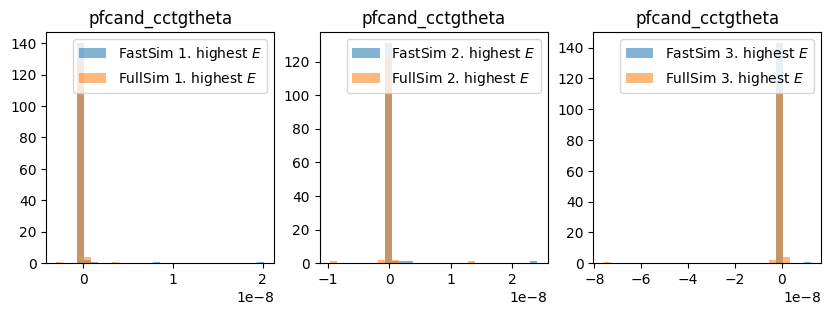

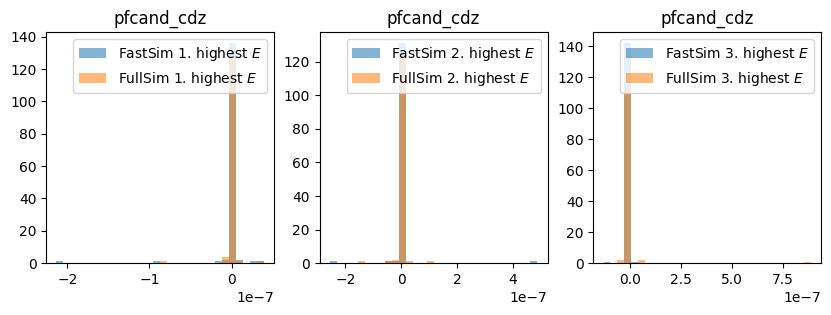

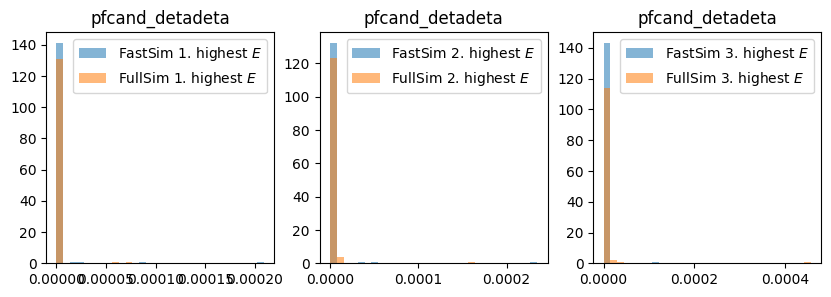

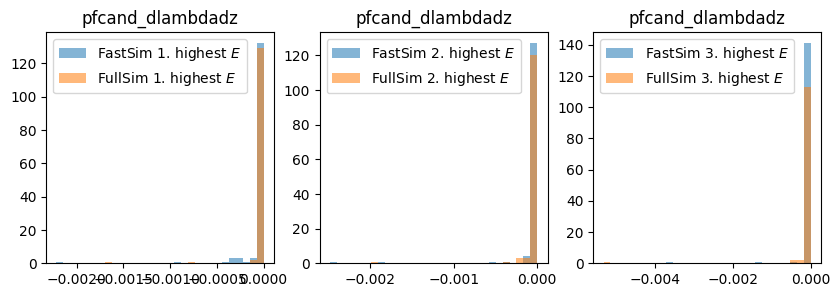

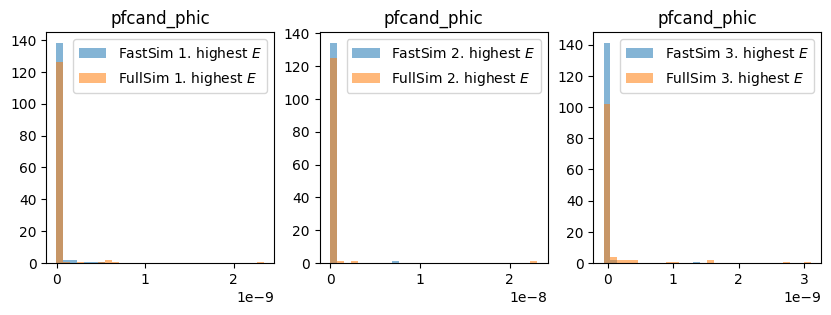

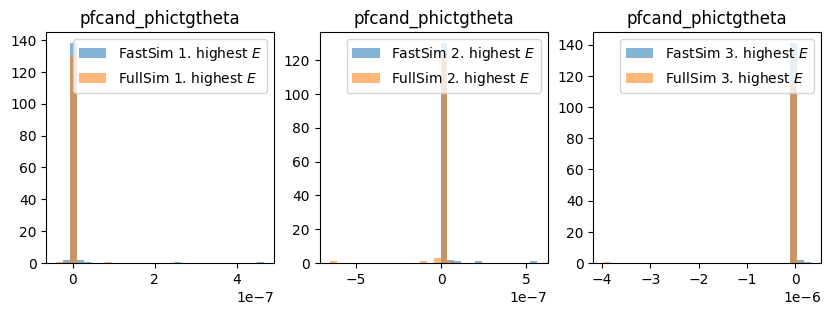

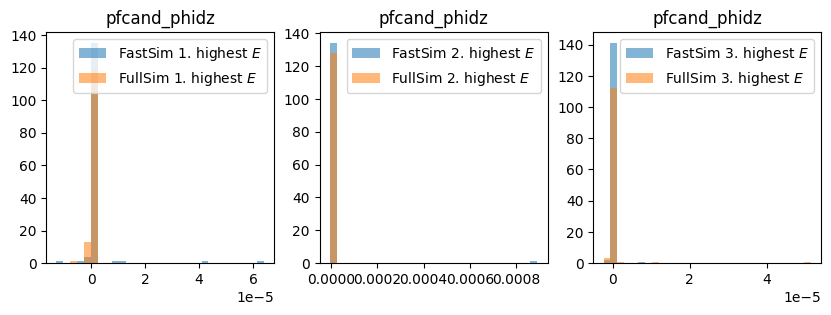

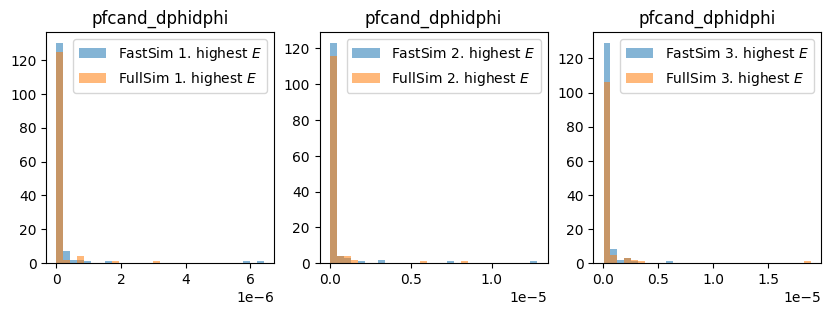

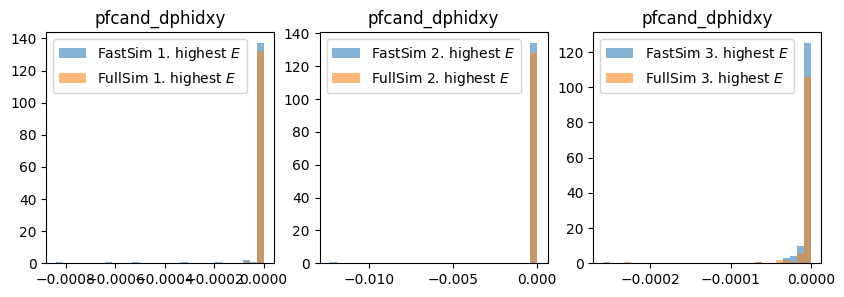

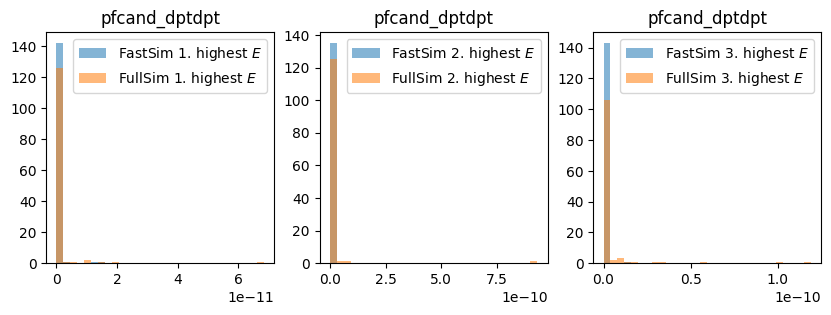

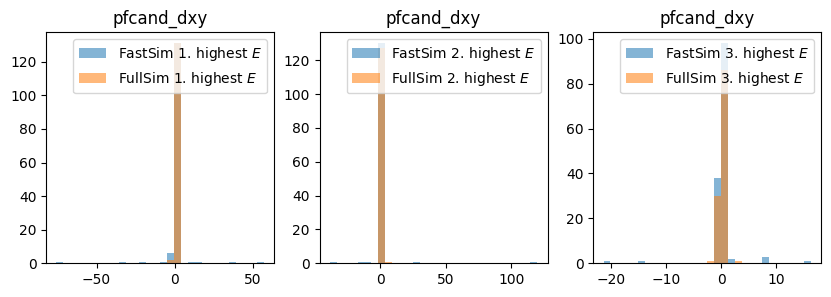

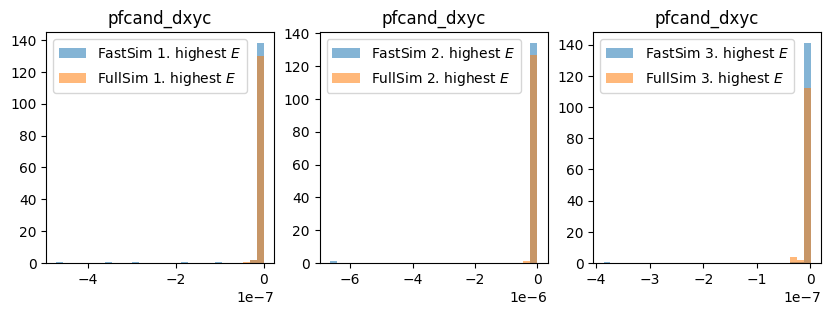

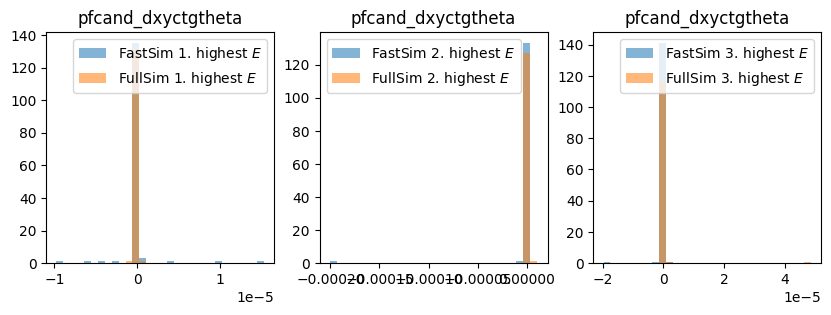

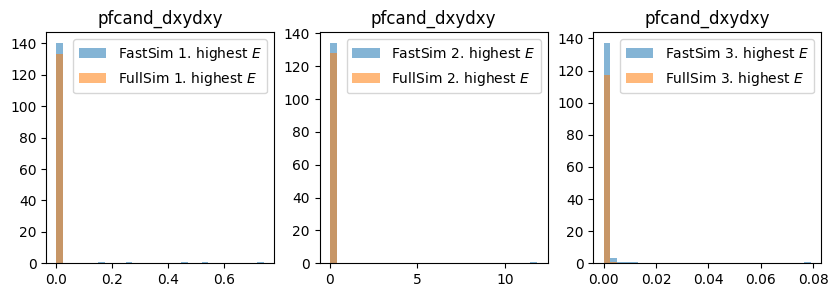

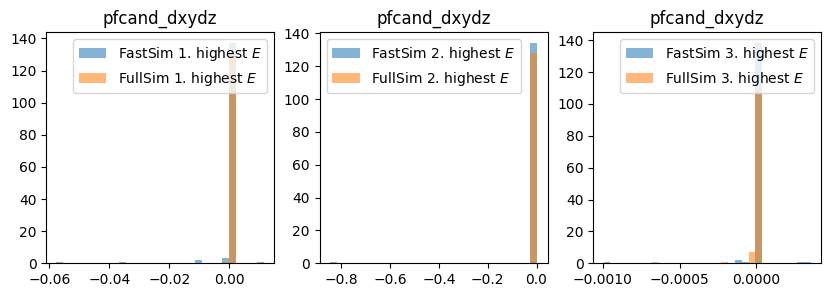

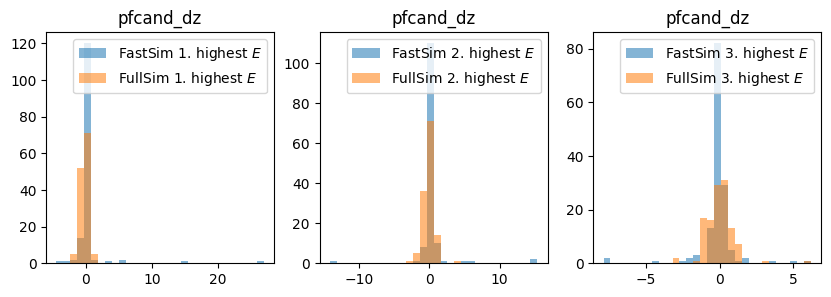

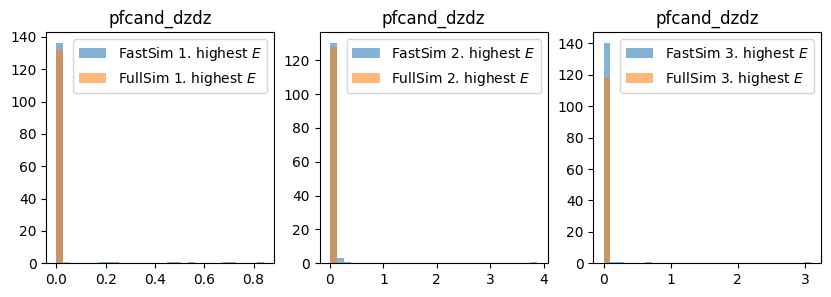

In [23]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']


for key in keys:
    plot_key_highest_e_part_no9(key, bins=30)

FCCAnalyses https://github.com/HEP-FCC/FCCAnalyses/blob/master/examples/FCCee/weaver/config.py

In [83]:
def plot_key_highest_e_chad_cov(key, k=3, range=None, bins=20, log=False):
    fig, axs = plt.subplots(1, k, figsize=(10,3))

    a_list = get_chad_elements(df_fa[key], index_fa)
    b_list = get_chad_elements(df_fu[key], index_fu)

    for i, ax in enumerate(axs.flat):
        a = a_list[i]
        b = b_list[i]
        a = a[a!=-9]
        b = b[b!=-9]

        if range == None:
            combined_min = min(a.min(), b.min())
            combined_max = max(a.max(), b.max())
            combined_range = (combined_min, combined_max)
        else:
            combined_range = range
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        if log:
            ax.set_yscale('log')
        ax.legend()
        
    plt.show()

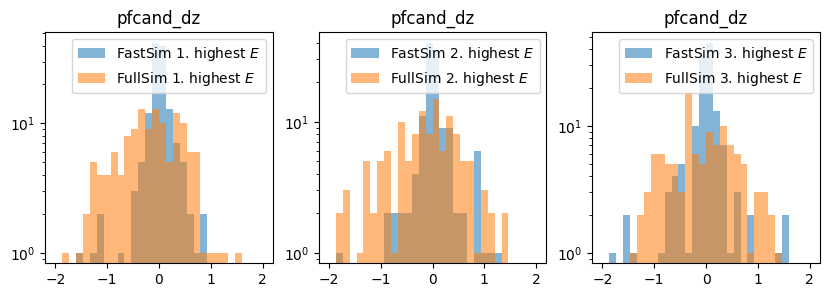

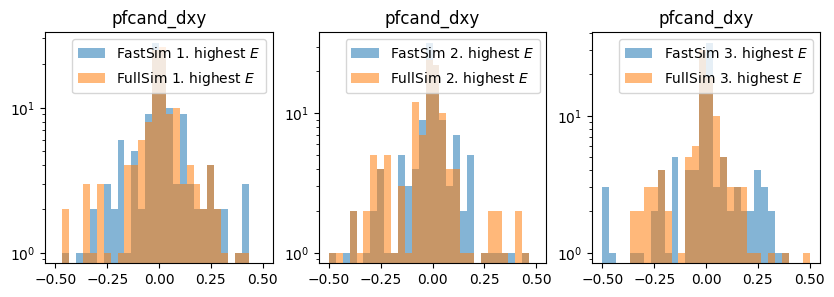

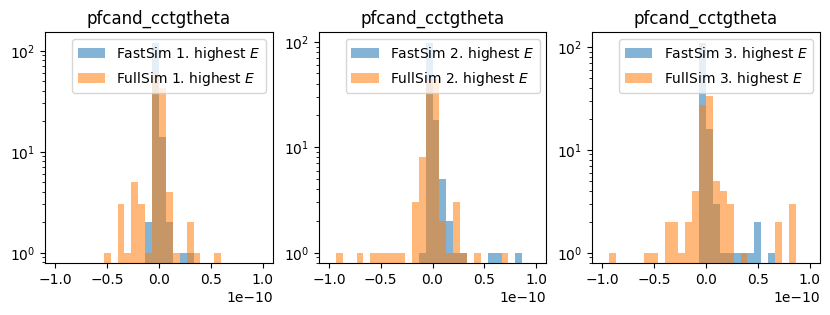

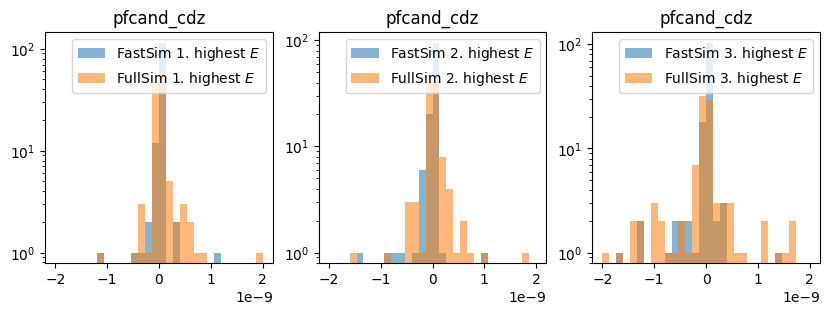

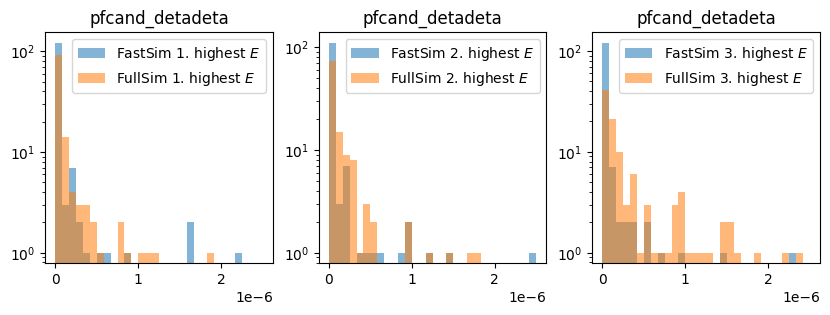

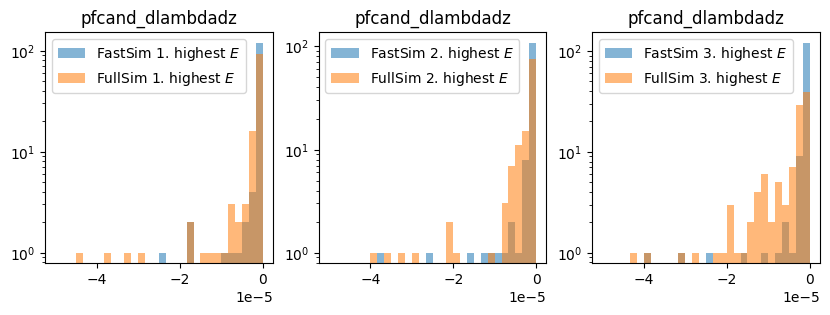

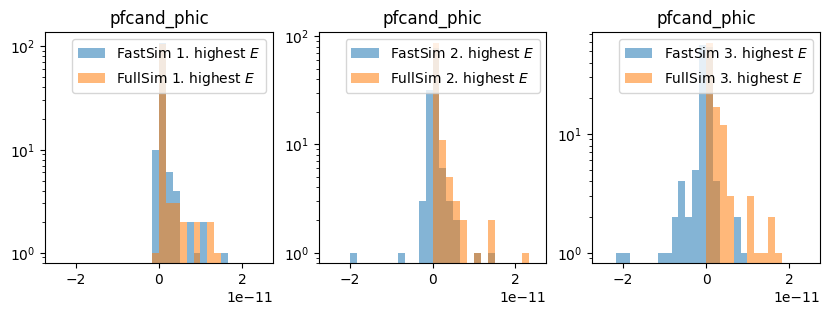

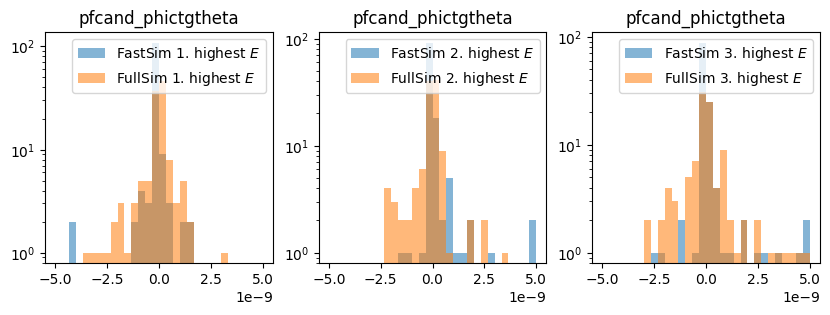

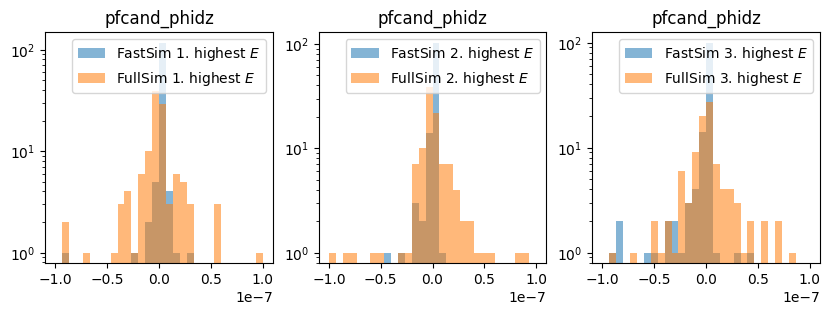

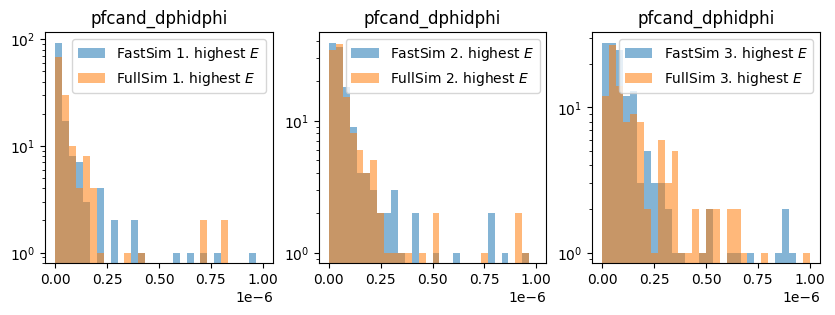

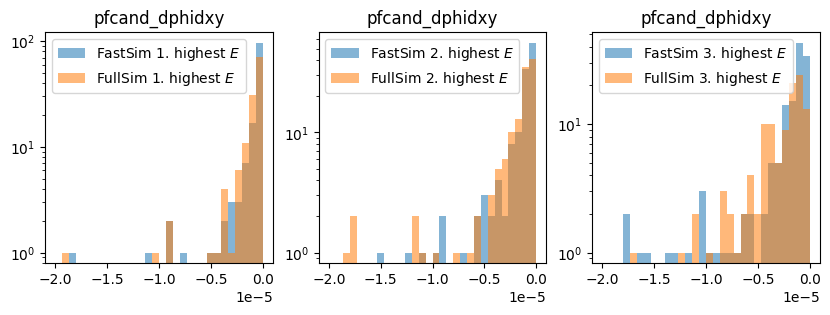

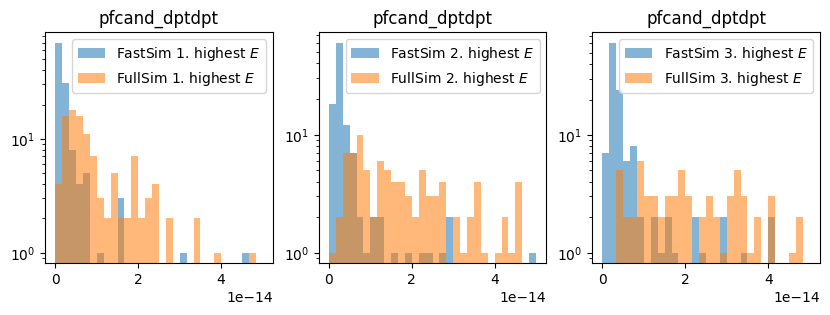

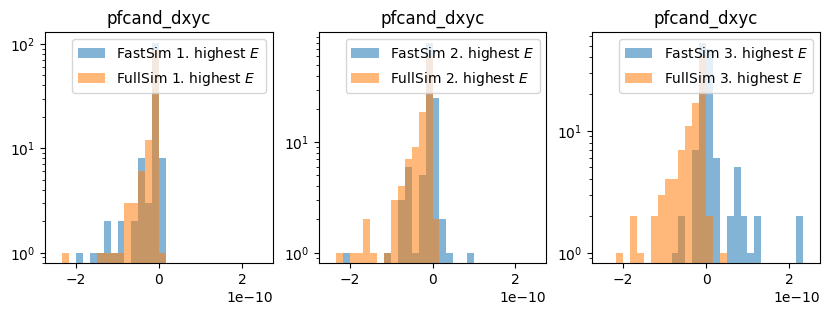

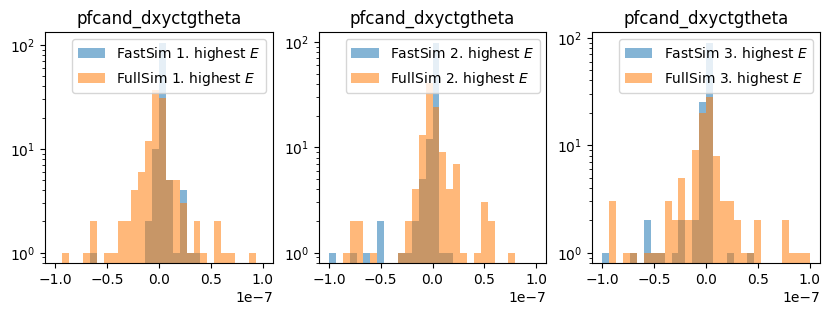

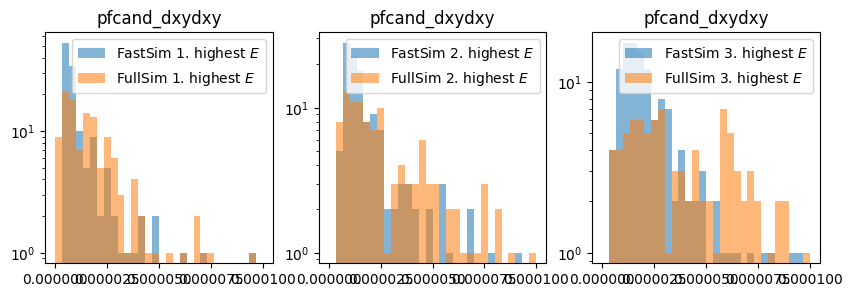

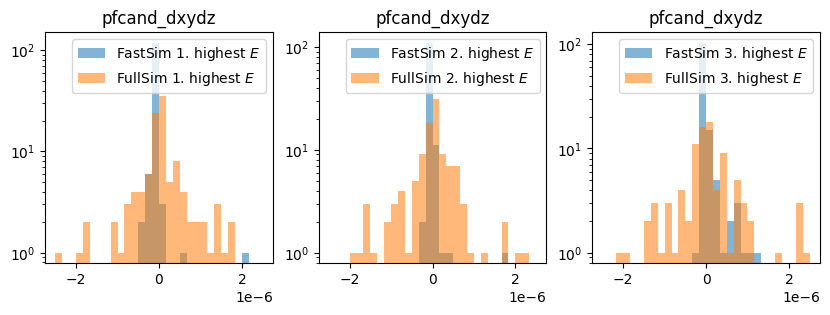

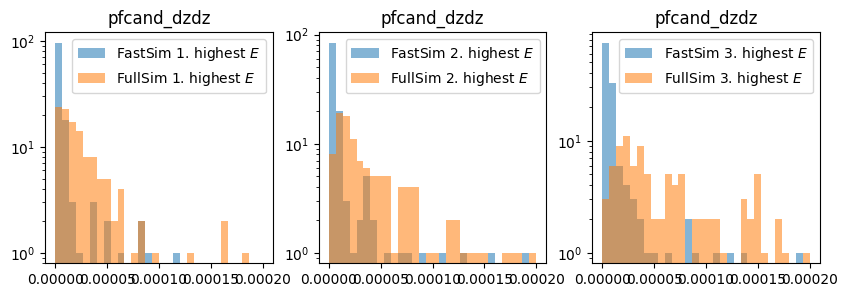

In [136]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = ['pfcand_dz',
        'pfcand_dxy',
        'pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dzdz']

ranges = {
    'pfcand_dz': [-2, 2],
    'pfcand_dxy': [-0.5, 0.5],
    'pfcand_cctgtheta': [-1e-10, 1e-10],
    'pfcand_cdz': [-0.2e-08, 0.2e-08],
    'pfcand_detadeta': [0, 0.25e-5],
    'pfcand_dlambdadz': [-0.05e-3, 0],
    'pfcand_phic': [-0.25e-10, 0.25e-10],
    'pfcand_phictgtheta': [-0.5e-08, 0.5e-08], 
    'pfcand_phidz': [-0.1e-6, 0.1e-6],
    'pfcand_dphidphi': [0.0, 1e-6], 
    'pfcand_dphidxy': [-2e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 2e-4],
}

for key in keys:
    plot_key_highest_e_chad_cov(key, bins=30, range=ranges[key], log=True)

Off are: 
- `dz` wider in FullSim
- `dptdpt` not same distribution
- `dxydz` wider in FullSim
- `dzdz` wider in FullSim

There are so many outliner, quite hard to compare...

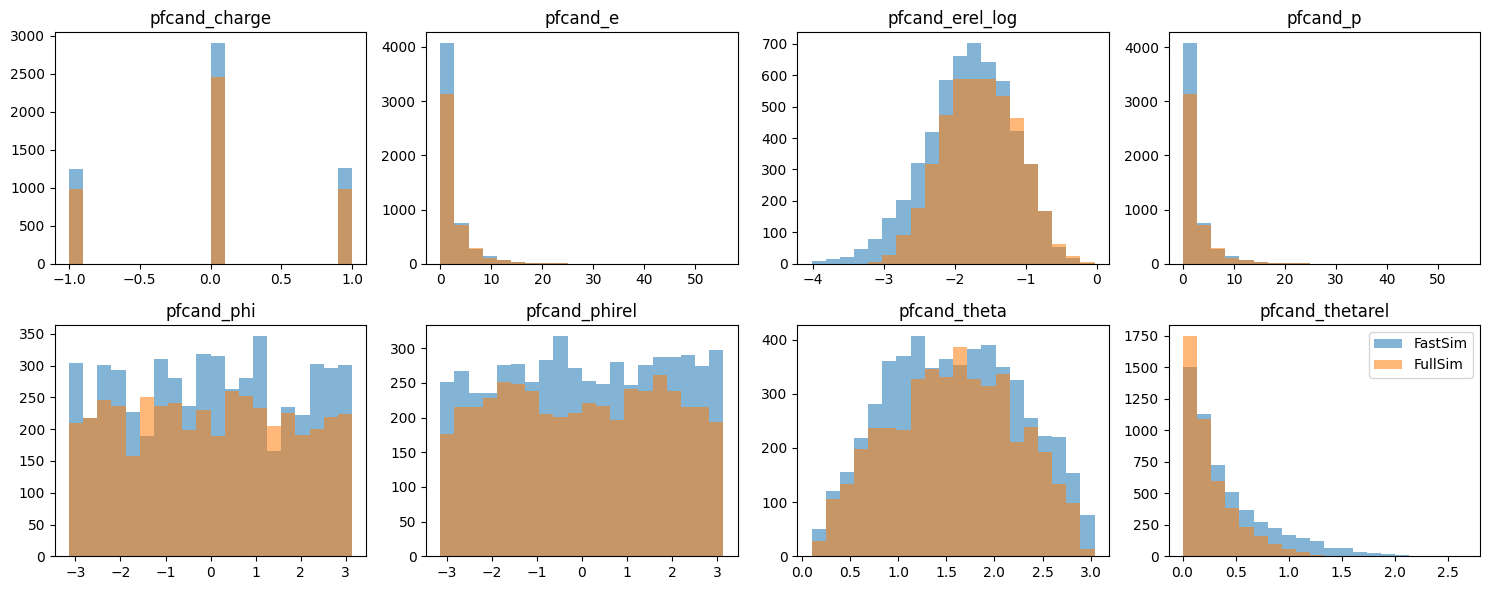

In [24]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

histograms(keys, 2, 4, figsize=(15, 6), bins=20, conc=True)

In [25]:
print(df_fa['pfcand_erel_log'].shape)
print(df_fu['pfcand_erel_log'].shape)

(200,)
(200,)


Looks good now :-) More nconst in Fastsim?

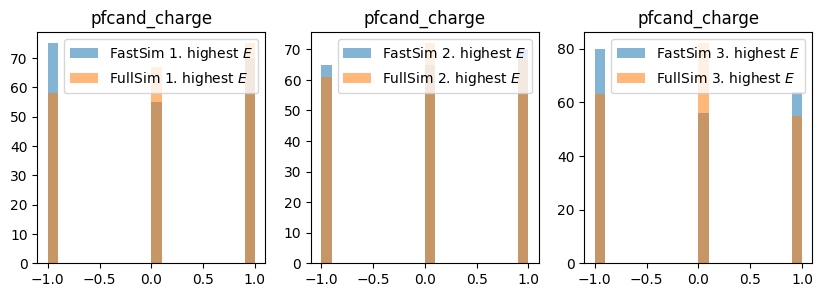

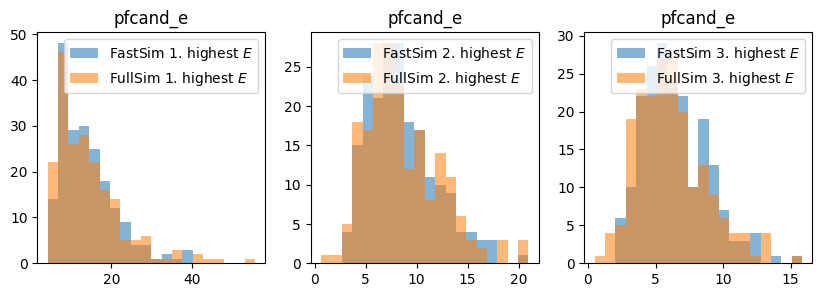

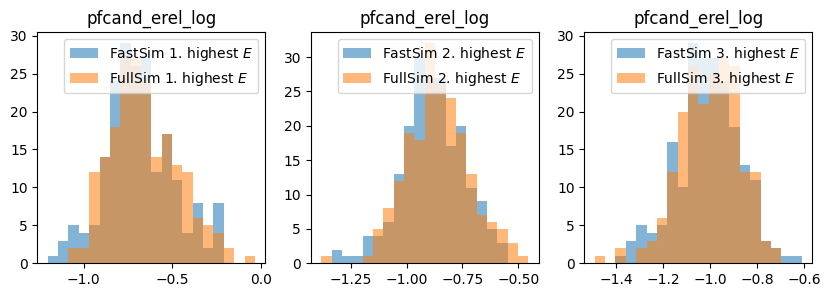

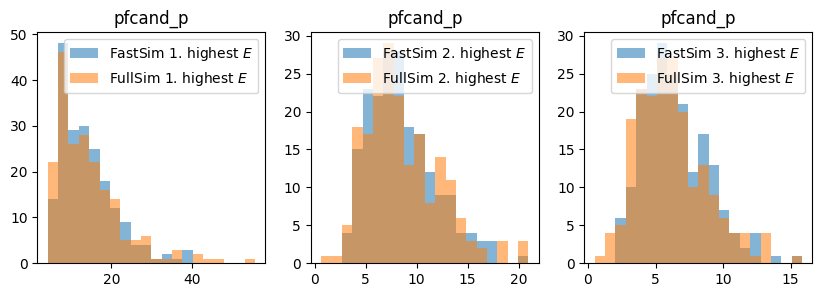

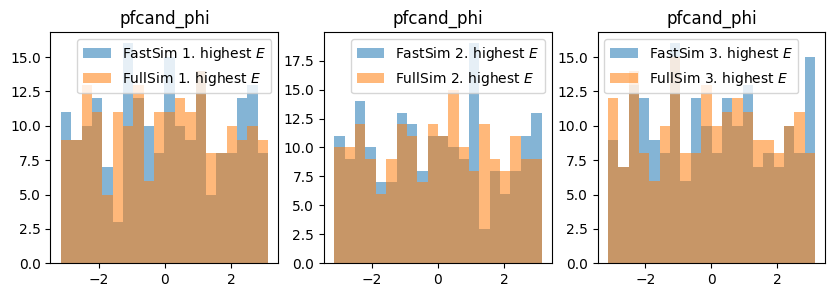

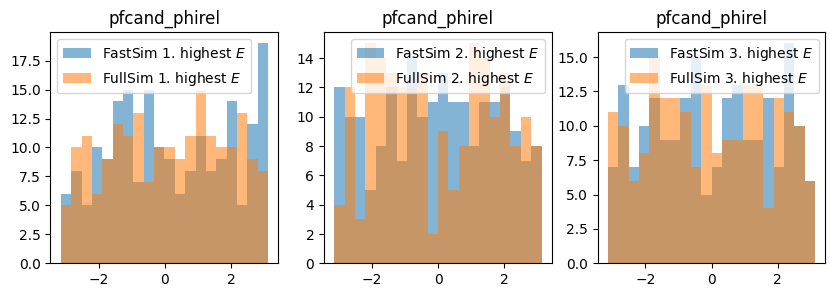

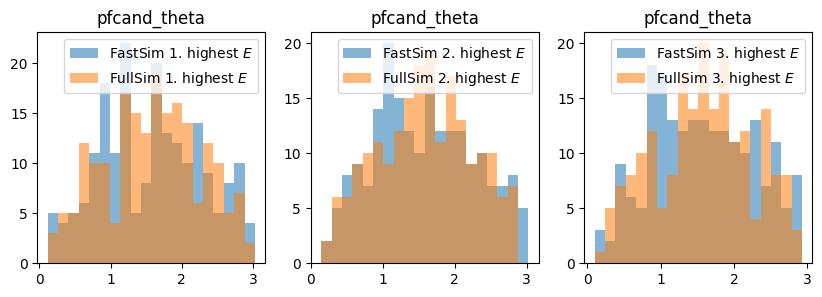

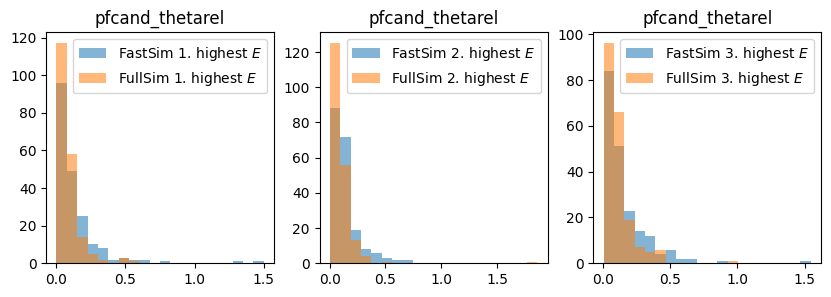

In [26]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

for key in keys:
    plot_key_highest_e_part(key)

Do these plots again but for charged hadrons: 

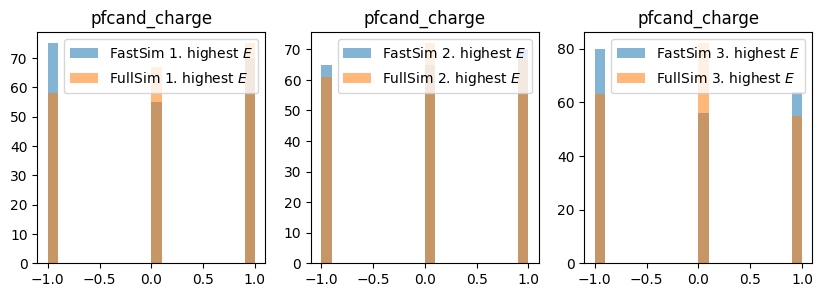

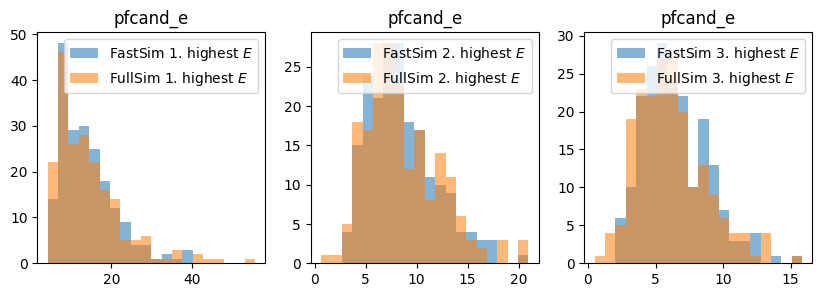

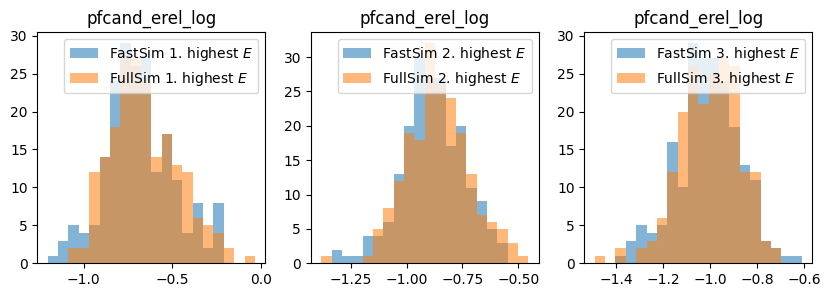

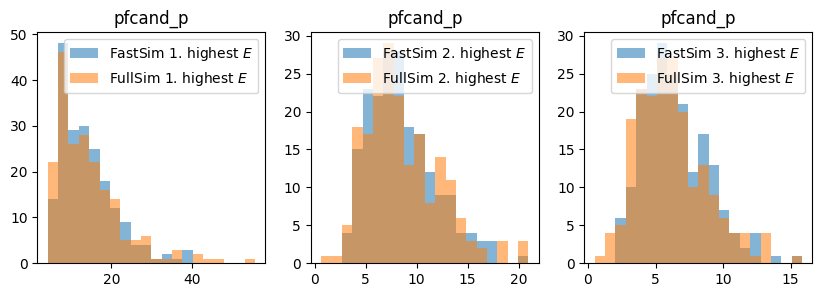

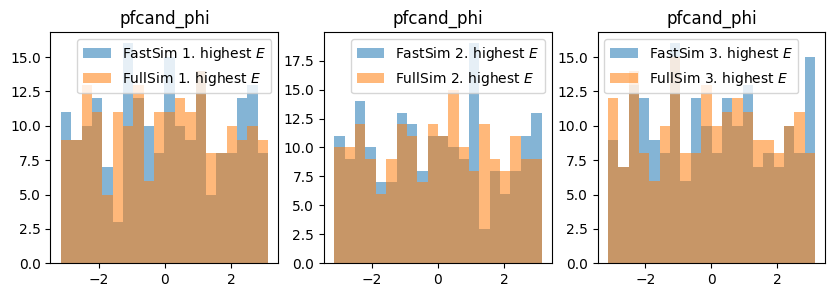

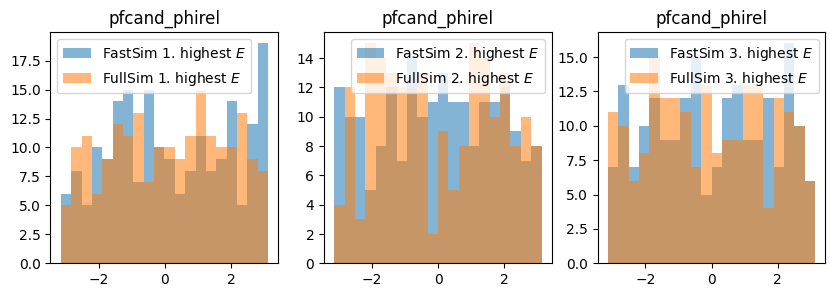

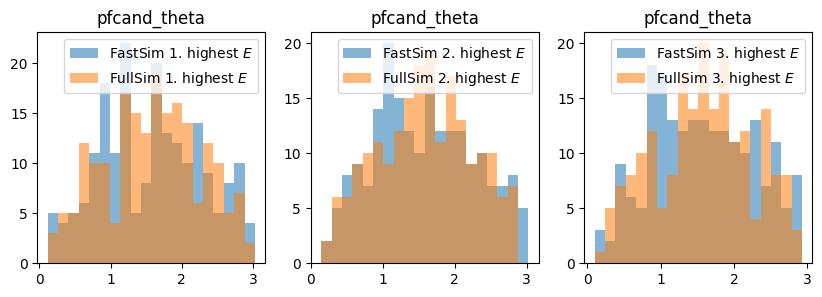

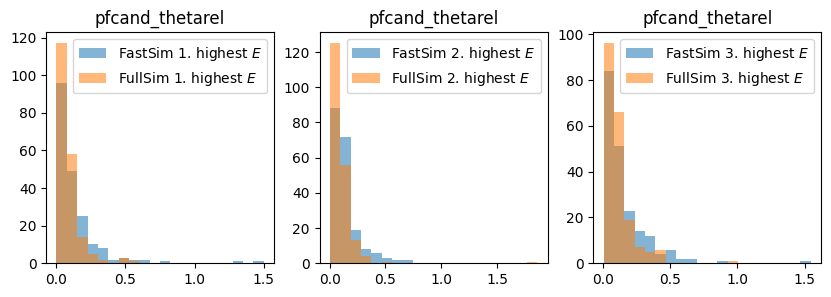

In [137]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

for key in keys:
    plot_key_highest_e_chad(key)

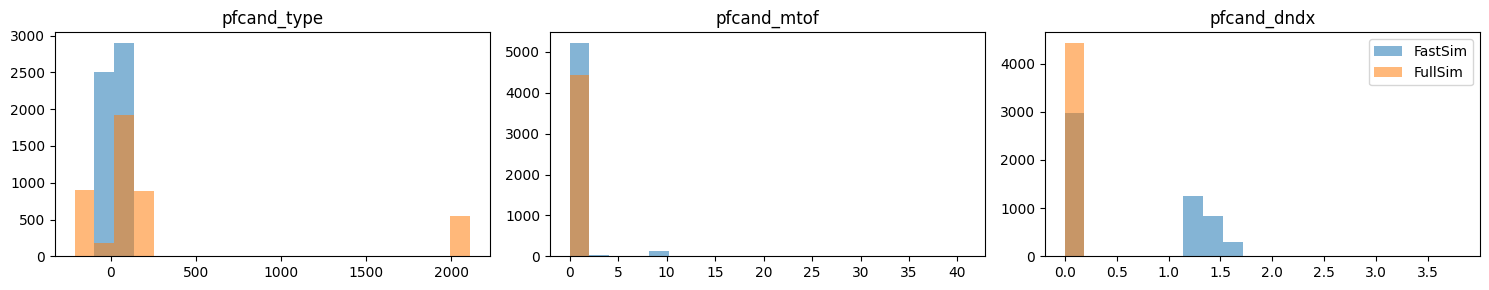

In [27]:
keys = ['pfcand_type', 'pfcand_mtof', 'pfcand_dndx']

histograms(keys, 1, 3, figsize=(15, 3), bins=20, conc=True)

it's normal that `pfcand_mtof` is off and `pfcand_dndx` because it set them to zero. 

But `pfcand_type` not... 

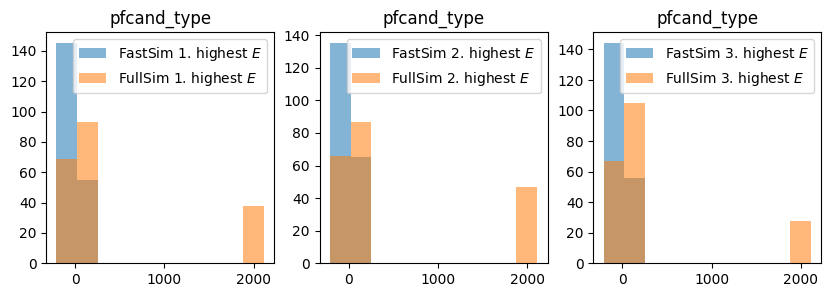

In [28]:
plot_key_highest_e_part('pfcand_type', k=3, bins=10)

In [29]:
from collections import defaultdict

In [30]:
def count_values(arrays, flatten=True):
    count_dict = defaultdict(int)
    
    # Flatten the array of arrays
    if flatten:
        flattened = np.concatenate(arrays)
    else:
        flattened = arrays
    
    # Count each value in the flattened array
    for value in flattened:
        count_dict[value] += 1
    
    return dict(count_dict)

In [31]:
count_values(df_fa['pfcand_type'])

{0.0: 2507, 22.0: 2678, 130.0: 223}

In [32]:
count_values(df_fu['pfcand_type'])

{211: 883, -211: 896, 22: 1921, 2112: 543, 11: 66, -11: 73, 13: 24, -13: 22}

In [33]:
np.sum(df_fu['jet_nnhad']) #543

543

In [34]:
np.sum(df_fu['jet_nchad']) #883 + 896 = 1779 check

1779

Well, we see that we have a lot more particle typed identified in full sim than in fast sim. FastSim has 0 while Fullsim doesn't have that option.

## Open questions
- keys (three more in fullsim - we need them?)
- how to check if tree structure is the same?
- `recojet_isX` is wrong - how to deal with that?
- which values are MC and with one reconstructed?
- SIP sig values:-9 doesn't make sense
- covariance values ok?
- `pfcand_anglerel` are off - why?
- `pfcand_type`: different values and handle 0?